In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
import pandas as pd

nest_asyncio.apply()  # 

In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

In [4]:

%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [5]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [6]:
# list of selected scenario tokens
from tokens import selected_scenario_tokens, modifiable_scenario_tokens

print(selected_scenario_tokens[0:3])
print(modifiable_scenario_tokens[0:3])

selected_scenario_tokens = ["fa01caf734875df7"]

['d6234553edc95d50', '98ddd7851e445b7a', '5ac5795b9b5851e8']
['014c7f3502d4597d', '02828821ef045829', '02fa9b8d43465e0d']


In [7]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts

left_turn_types = [
    "stopping_at_crosswalk",
    "high_lateral_acceleration",
    "near_multiple_vehicles",
    "on_stopline_stop_sign",
    "near_long_vehicle",
    "unknown",
    "near_barrier_on_driveable",
    "near_high_speed_vehicle",
]
scenario_types = [
    "starting_left_turn",
    # "accelerating_at_traffic_light_with_lead",
    # "crossed_by_bike",
    # "crossed_by_vehicle",
    # "on_intersection",
    # "on_stopline_crosswalk",
    # "on_stopline_stop_sign",
    # "on_stopline_traffic_light",
    # "on_traffic_light_intersection",
    # "starting_protected_cross_turn",
    # "starting_protected_noncross_turn",
    "starting_right_turn",
    "starting_straight_stop_sign_intersection_traversal",
    "starting_straight_traffic_light_intersection_traversal",
    # "starting_u_turn",
    "starting_unprotected_cross_turn",
    "starting_unprotected_noncross_turn",
    # "stationary_at_crosswalk",
    # "stationary_at_traffic_light_with_lead",
    # "stationary_at_traffic_light_without_lead",
    # "traversing_crosswalk",
    "traversing_intersection",
    "traversing_traffic_light_intersection",
]

left_turn_potential = [
    "starting_left_turn",
    "starting_unprotected_cross_turn",
]

# scenario_types = ['stationary_at_traffic_light_without_lead']

scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
DATASET_PARAMS = [
    f"scenario_builder={scenario_builder}",
    "scenario_filter=all_scenarios",  # [all_scenarios, val14_split]
    f"scenario_filter.scenario_types={scenario_types}",  # there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
    "scenario_filter.ego_displacement_minimum_m=10",  # use scenarios where the ego vehicle moves at least 10m
    #    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
    # "scenario_filter.ego_start_speed_threshold=5",  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
    #    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
    "scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]",  # select multiple [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
    # "scenario_filter.limit_total_scenarios=0.05",  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
    "scenario_filter.num_scenarios_per_type=20",  # use 10 scenarios per scenario type
    # f"scenario_filter.scenario_tokens={selected_scenario_tokens}",  # List of scenarios to include (token)
    #'scenario_filter.log_names=["2021.08.24.20.03.01_veh-45_01091_01622"]',  # specific scenrios to simulate
    # turn off if you are selecting scenarios manually. turn on for initial filtering (0.05 gives us 1 scenario per second)
]
urban_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt"
gc_pgp_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/gc_pgp_checkpoint.ckpt"
hybrid_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg_occ = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        # "model=gc_pgp_model",
        # "model.aggregator.pre_train=false",
        # "planner.ml_planner.model_config=${model}",
        # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
        # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
        # "+observation.model=gc_pgp_model",
        # "+observation.model.aggregator.pre_train=false",
        # "+observation.model_config=${model}",
        # f"+observation.checkpoint_path={gc_pgp_ckpt}",
        f"observation.planner_type=pdm_closed",
        # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
        f"observation.occlusion_cfg.occlusion=True",
        f"observation.occlusion_cfg.manager_type=wedge",
        f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
        f"+observation.occlusion_cfg.notice_threshold=1.0",
        "+modify_scenario_simulations=true",
        "+modifier_types=[conflict-and-occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right, oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection]
        "+occlusion=True",
        "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
        "+occlusion.uncloak_reaction_time=1.5",  # 0.1
        "+occlusion.notice_threshold=1.0",  # 0.1
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder_occ = cfg_occ.output_dir
print('output_folder_occ = "' + output_folder_occ + '"')


# closed mixed for simulation
# "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
# "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
# # "model=gc_pgp_model",
# # "model.aggregator.pre_train=false",
# # "planner.ml_planner.model_config=${model}",
# # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
# # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
# # "+observation.model=gc_pgp_model",
# # "+observation.model.aggregator.pre_train=false",
# # "+observation.model_config=${model}",
# # f"+observation.checkpoint_path={gc_pgp_ckpt}",
# f"observation.planner_type=pdm_closed",
# # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
# f"observation.occlusion_cfg.occlusion=true",
# f"observation.occlusion_cfg.manager_type=wedge",
# f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
# f"+observation.occlusion_cfg.notice_threshold=1.0",
# "+modify_scenario_simulations=true",
# "+modifier_types=[occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right]
# "+occlusion=true",
# "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
# "+occlusion.uncloak_reaction_time=1.0",
# "+occlusion.notice_threshold=0.1",
# "worker=ray_distributed",  # [sequential, ray_distributed]
# "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
# *DATASET_PARAMS,

# openloop config for finding risky scenarios
# f"scenario_builder={scenario_builder}",
# "scenario_filter=all_scenarios",  # [all_scenarios, val14_split]
# # f"scenario_filter.scenario_types={left_turn_types}",  # there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
# "scenario_filter.ego_displacement_minimum_m=10",  # use scenarios where the ego vehicle moves at least 10m
# #    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
# "scenario_filter.ego_start_speed_threshold=5",  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
# #    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
# "scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood]",  # select multiple [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
# # "scenario_filter.num_scenarios_per_type=300",  # use 10 scenarios per scenario type
# # f"scenario_filter.scenario_tokens={selected_scenario_tokens}",  # List of scenarios to include (token)
# #'scenario_filter.log_names=["2021.08.24.20.03.01_veh-45_01091_01622"]',  # specific scenrios to simulate
# "scenario_filter.limit_total_scenarios=0.01",  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
# # turn off if you are selecting scenarios manually. turn on for initial filtering (0.05 gives us 1 scenario per second)


# "+simulation=open_loop_boxes",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
#         "planner=log_future_planner",  # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
#         "ego_controller=perfect_tracking_controller",
#         "worker=ray_distributed",  # [sequential, ray_distributed]
#         "+occlusion=true",  # [true, false]
#         "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
#         "+occlusion.uncloak_reaction_time=1.5",
#         "+occlusion.notice_threshold=1.0",
#         # "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
#         *DATASET_PARAMS,


# output folders for runs:
# closed_loop_reactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
# overall score: 0.5041, ego_at_fault_collisions: 363

# closed_loop_reactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13"
# overall score: 0.5041, ego_at_fault_collisions: 357

# closed_loop_nonreactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.02.01.14"
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41"
# overall score: , ego_at_fault_collisions:

# closed_loop_nonreactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23"
# overall score: , ego_at_fault_collisions:

# closed_loop_reactive_agents, wedge occlusions, gc_pgp
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44"
# overall score: , ego_at_fault_collisions:

# 'closed_loop_reactive_agents, occlusions = False, gc_pgp'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30"

# 'closed_loop_reactive_agents, occlusions = False, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28"

# 'closed_loop_reactive_agents,  wedge occlusions, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"

# # be8c7a230b9c5b4e_oncoming_vehicle_injection_for_left_turn_and_occlusion_injection_0
# # output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.14.14.14.30"
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.14.14.38.02"

default_simulation
output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.06.45"


# Now we can run with the following

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2024-02-28 20:06:46,177 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-02-28 20:06:46,179 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-02-28 20:06:47,789	INFO worker.py:1636 -- Started a local Ray instance.


2024-02-28 20:06:48,525 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-02-28 20:06:48,526 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-02-28 20:06:48,526 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-02-28 20:06:48,526 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-02-28 20:06:48,526 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.06.45

2024-02-28 20:06:48,528 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]
(raylet) [2024-02-28 20:06:57,763 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 668486148096; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-02-28 20:06:59,494 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:83}  Building metric engines...
2024-02-28 20:06:59,749 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:85}  Building metric engines...DONE
2024-02-28 20:06:59,750 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:89}  Building simulations from 152 scenarios...
2024-02-28 20:07:01,817 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:151}  Modyfing Scenarios...
1 0 are the number of cpus and gpus
2024-02-28 20:07:01,817 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:116}  Submitting 152 tasks!
(wrapped_fn pid=10686) Warning: ego in scenario 0bd3ee0c8e1357b2 has no conflict lanes intersecting its path
(wrapped_fn pid=10686) Warning: ego in scenario 1edea76de3975817 has no conflict lanes intersecting its path
(wrapped_fn

(raylet) [2024-02-28 20:07:07,769 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 668486135808; capacity: 16125711347712. Object creation will fail if spilling is required.


(wrapped_fn pid=10664) Warning: ego in scenario 22cda6ef461e5666 has no conflict lanes intersecting its path [repeated 10x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(wrapped_fn pid=10667) Left turn 18405 in scenario 4a09d29d43815d7b has a red traffic light [repeated 2x across cluster]


(raylet) [2024-02-28 20:07:17,776 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 668486127616; capacity: 16125711347712. Object creation will fail if spilling is required.


(wrapped_fn pid=10656) Warning: ego in scenario 7fad2771b3445c4c has no conflict lanes intersecting its path [repeated 8x across cluster]
(wrapped_fn pid=10660) Left turn 70518 in scenario 6ea37f738f3f5907 has a red traffic light [repeated 2x across cluster]
(wrapped_fn pid=10657) Warning: ego in scenario 91ecf9ddc57f5a11 has no conflict lanes intersecting its path [repeated 8x across cluster]
(wrapped_fn pid=10671) Warning: ego in scenario 91ecf9ddc57f5a11 has no conflict lanes intersecting its path


(raylet) [2024-02-28 20:07:27,783 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 668486123520; capacity: 16125711347712. Object creation will fail if spilling is required.
Ray objects:  48%|████▊     | 73/152 [00:00<00:00, 631.30it/s]

(wrapped_fn pid=10668) Left turn 70518 in scenario aaa28af94ac15ae4 has a red traffic light
(wrapped_fn pid=10657) Left turn 70518 in scenario aaa28af94ac15ae4 has a red traffic light
(wrapped_fn pid=10667) Warning: ego in scenario ac859a9b54ad59de has no conflict lanes intersecting its path
(wrapped_fn pid=10671) Left turn 18452 in scenario b683e3722ee8570d has a red traffic light [repeated 2x across cluster]
(wrapped_fn pid=10668) Warning: ego in scenario c60cd30825795e00 has no conflict lanes intersecting its path [repeated 5x across cluster]


(raylet) [2024-02-28 20:07:37,790 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 668486119424; capacity: 16125711347712. Object creation will fail if spilling is required.


(wrapped_fn pid=10658) Left turn 18590 in scenario e6bb1d7221af5462 has a red traffic light [repeated 3x across cluster]
(wrapped_fn pid=10664) Warning: ego in scenario eaeb329bac135fb3 has no conflict lanes intersecting its path [repeated 5x across cluster]


(raylet) [2024-02-28 20:07:47,797 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 668486090752; capacity: 16125711347712. Object creation will fail if spilling is required.
Ray objects:  81%|████████  | 123/152 [00:19<00:05,  5.21it/s](raylet) [2024-02-28 20:07:57,804 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 668485955584; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-02-28 20:08:07,810 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 668485955584; capacity: 16125711347712. Object creation will fail if spilling is required.
Ray objects:  96%|█████████▌| 146/152 [00:46<00:03,  1.84it/s](raylet) [2024-02-28 20:08:17,815 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp

2024-02-28 20:11:21,604 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 8 modified scenarios from scenario with token: 014ef3bc5af25944.


100%|██████████| 8/8 [00:00<00:00, 835.17it/s]
0it [00:00, ?it/s]

2024-02-28 20:11:21,617 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 5 modified scenarios from scenario with token: 0489f98ba4695a8f.


100%|██████████| 5/5 [00:00<00:00, 830.65it/s]
0it [00:00, ?it/s]

2024-02-28 20:11:21,625 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 10 modified scenarios from scenario with token: 0c308ff01686526d.


100%|██████████| 10/10 [00:00<00:00, 825.80it/s]
0it [00:00, ?it/s]

2024-02-28 20:11:21,640 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 3 modified scenarios from scenario with token: 1733f3612f995a04.


100%|██████████| 3/3 [00:00<00:00, 761.91it/s]
0it [00:00, ?it/s]

2024-02-28 20:11:21,647 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 9 modified scenarios from scenario with token: 2b430abcf49554c7.


100%|██████████| 9/9 [00:00<00:00, 840.92it/s]
0it [00:00, ?it/s]

2024-02-28 20:11:21,660 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 8 modified scenarios from scenario with token: 30a56d9819f5500a.


100%|██████████| 8/8 [00:00<00:00, 836.27it/s]
0it [00:00, ?it/s]

2024-02-28 20:11:21,673 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 1 modified scenarios from scenario with token: 33033416cd21523d.


100%|██████████| 1/1 [00:00<00:00, 686.80it/s]
0it [00:00, ?it/s]

2024-02-28 20:11:21,677 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 11 modified scenarios from scenario with token: 3ad61242db035638.


100%|██████████| 11/11 [00:00<00:00, 815.67it/s]
0it [00:00, ?it/s]

2024-02-28 20:11:21,693 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 6 modified scenarios from scenario with token: 3ebdf29d55045ed0.


100%|██████████| 6/6 [00:00<00:00, 835.46it/s]
0it [00:00, ?it/s]

2024-02-28 20:11:21,703 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 8 modified scenarios from scenario with token: 4e5f13bdc96e552f.


100%|██████████| 8/8 [00:00<00:00, 873.22it/s]
52it [00:00, 466.66it/s]

2024-02-28 20:11:21,716 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 3 modified scenarios from scenario with token: 59ef9500cad45425.


100%|██████████| 3/3 [00:00<00:00, 799.98it/s]
52it [00:00, 466.66it/s]

2024-02-28 20:11:21,722 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 8 modified scenarios from scenario with token: 6895e06f4b645c9b.


100%|██████████| 8/8 [00:00<00:00, 847.66it/s]
52it [00:00, 466.66it/s]

2024-02-28 20:11:21,735 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 3 modified scenarios from scenario with token: 764f667f1ffa5b26.


100%|██████████| 3/3 [00:00<00:00, 800.95it/s]
52it [00:00, 466.66it/s]

2024-02-28 20:11:21,741 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 2 modified scenarios from scenario with token: 7c518fcf126251e5.


100%|██████████| 2/2 [00:00<00:00, 670.34it/s]
52it [00:00, 466.66it/s]

2024-02-28 20:11:21,747 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 33 modified scenarios from scenario with token: 8b80aa05d88b518b.


100%|██████████| 33/33 [00:00<00:00, 818.48it/s]
52it [00:00, 466.66it/s]

2024-02-28 20:11:21,790 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 3 modified scenarios from scenario with token: 9e306573ac3c53dc.


100%|██████████| 3/3 [00:00<00:00, 782.81it/s]
52it [00:00, 466.66it/s]

2024-02-28 20:11:21,797 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 3 modified scenarios from scenario with token: a41ed0bc8aff506b.


100%|██████████| 3/3 [00:00<00:00, 636.37it/s]
52it [00:00, 466.66it/s]

2024-02-28 20:11:21,805 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 6 modified scenarios from scenario with token: a7f1731ff7c35faa.


100%|██████████| 6/6 [00:00<00:00, 794.63it/s]
52it [00:00, 466.66it/s]

2024-02-28 20:11:21,815 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 9 modified scenarios from scenario with token: a91bbdd53829507d.


100%|██████████| 9/9 [00:00<00:00, 748.03it/s]
101it [00:00, 442.87it/s]

2024-02-28 20:11:21,831 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 30 modified scenarios from scenario with token: bd72e5b0d1265eec.


100%|██████████| 30/30 [00:00<00:00, 847.92it/s]
101it [00:00, 442.87it/s]

2024-02-28 20:11:21,869 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 8 modified scenarios from scenario with token: d5588e98c9a454da.


100%|██████████| 8/8 [00:00<00:00, 769.14it/s]
101it [00:00, 442.87it/s]

2024-02-28 20:11:21,882 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 6 modified scenarios from scenario with token: d6cb5239199b531c.


100%|██████████| 6/6 [00:00<00:00, 814.24it/s]
101it [00:00, 442.87it/s]

2024-02-28 20:11:21,892 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 14 modified scenarios from scenario with token: d8878c93341a583d.


100%|██████████| 14/14 [00:00<00:00, 800.13it/s]
101it [00:00, 442.87it/s]

2024-02-28 20:11:21,912 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 7 modified scenarios from scenario with token: f9fb1ccf7b0a5936.


100%|██████████| 7/7 [00:00<00:00, 849.79it/s]
101it [00:00, 442.87it/s]

2024-02-28 20:11:21,922 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:183}  Created 1 modified scenarios from scenario with token: fef8d90af3345bbe.


100%|██████████| 1/1 [00:00<00:00, 619.91it/s]
152it [00:00, 472.03it/s]


[
	'014ef3bc5af25944',
	'0489f98ba4695a8f',
	'0c308ff01686526d',
	'1733f3612f995a04',
	'2b430abcf49554c7',
	'30a56d9819f5500a',
	'33033416cd21523d',
	'3ad61242db035638',
	'3ebdf29d55045ed0',
	'4e5f13bdc96e552f',
	'59ef9500cad45425',
	'6895e06f4b645c9b',
	'764f667f1ffa5b26',
	'7c518fcf126251e5',
	'8b80aa05d88b518b',
	'9e306573ac3c53dc',
	'a41ed0bc8aff506b',
	'a7f1731ff7c35faa',
	'a91bbdd53829507d',
	'bd72e5b0d1265eec',
	'd5588e98c9a454da',
	'd6cb5239199b531c',
	'd8878c93341a583d',
	'f9fb1ccf7b0a5936',
	'fef8d90af3345bbe'
]
2024-02-28 20:11:21,937 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:202}  Created 205 modified scenarios from 152 scenarios, 25 of which were modifiable.
2024-02-28 20:11:21,937 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:203}  Building simulations...DONE!
2024-02-28 20:11:21,938 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:113}  Running simulation.

Ray objects:   0%|          | 0/205 [00:00<?, ?it/s](raylet) [2024-02-28 20:11:27,875 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 668486656000; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-02-28 20:11:37,882 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 668486619136; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-02-28 20:11:47,888 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 668486565888; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-02-28 20:11:57,895 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, availabl

2024-02-28 20:30:12,634 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 205
2024-02-28 20:30:12,634 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-02-28 20:30:12,635 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-02-28 20:30:12,674 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.06.45/runner_report.parquet
2024-02-28 20:30:12,674 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:23:26 [HH:MM:SS]
2024-02-28 20:30:14,959 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:02 [HH:MM:SS]
2024-02-28 20:30:15,068

Rendering histograms:   5%|▍         | 1/21 [00:00<00:04,  4.70it/s]

2024-02-28 20:30:15,564 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-28 20:30:15,566 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Rendering histograms:  14%|█▍        | 3/21 [00:00<00:02,  6.91it/s]

2024-02-28 20:30:15,809 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-28 20:30:15,810 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-28 20:30:15,813 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-28 20:30:15,815 INFO {/home/ehdykhne/miniconda3

Rendering histograms: 100%|██████████| 21/21 [00:02<00:00,  7.91it/s]
(raylet) [2024-02-28 20:30:18,630 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 665115566080; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-02-28 20:30:20,924 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:05 [HH:MM:SS]
2024-02-28 20:30:20,925 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:115}  Finished running simulation!


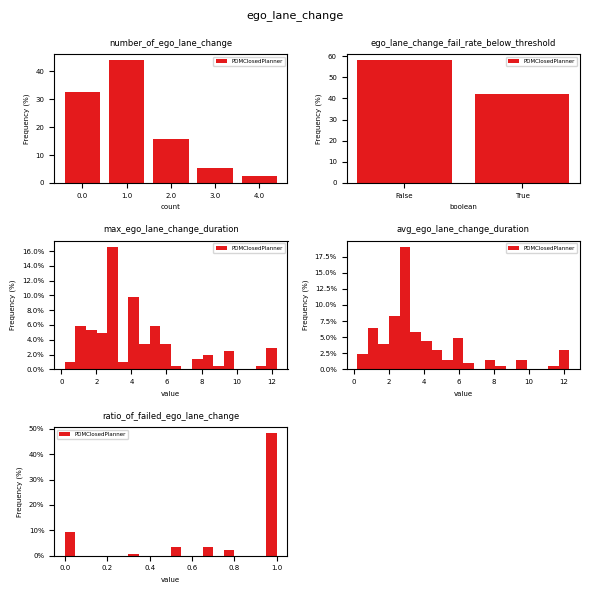

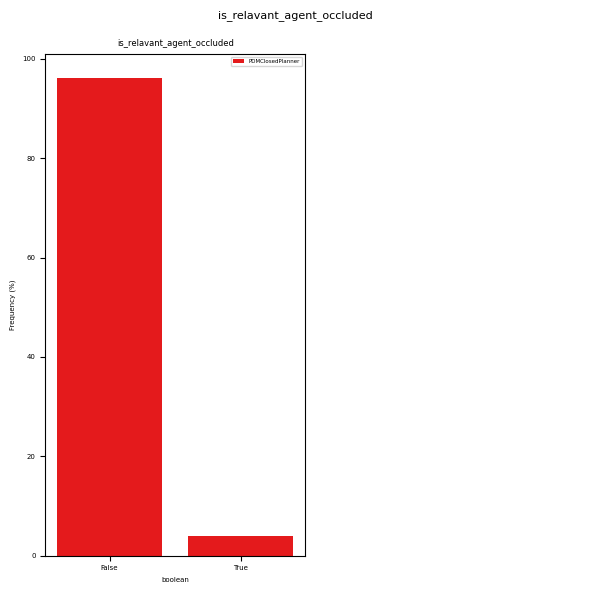

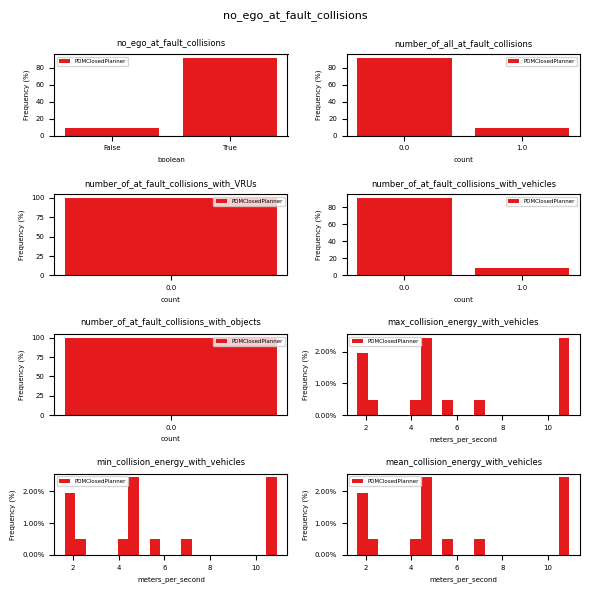

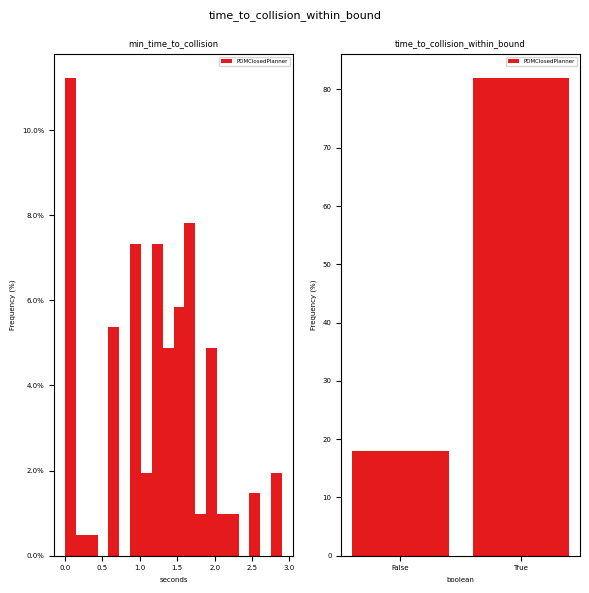

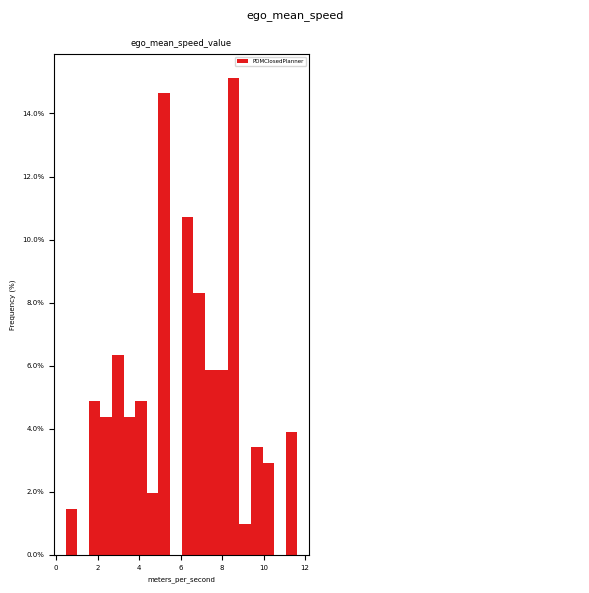

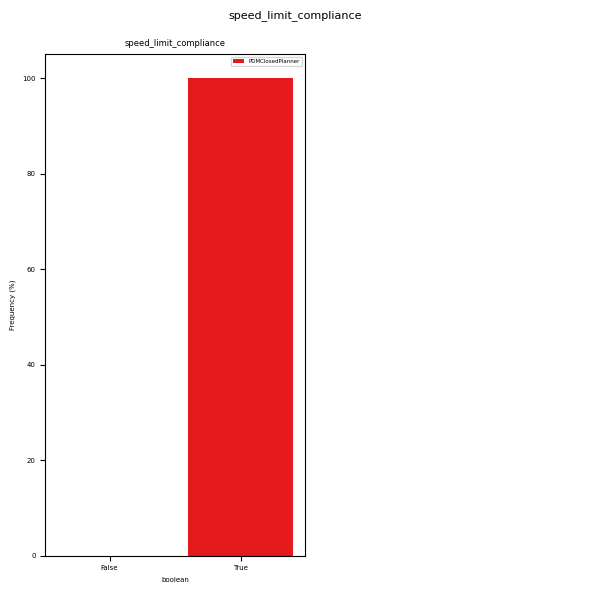

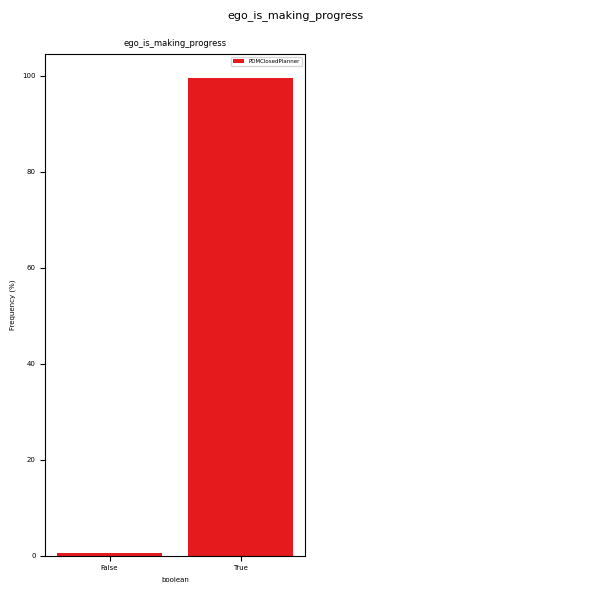

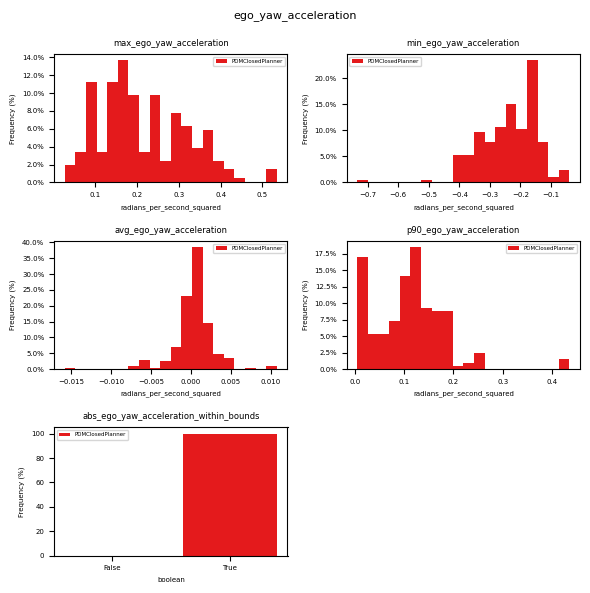

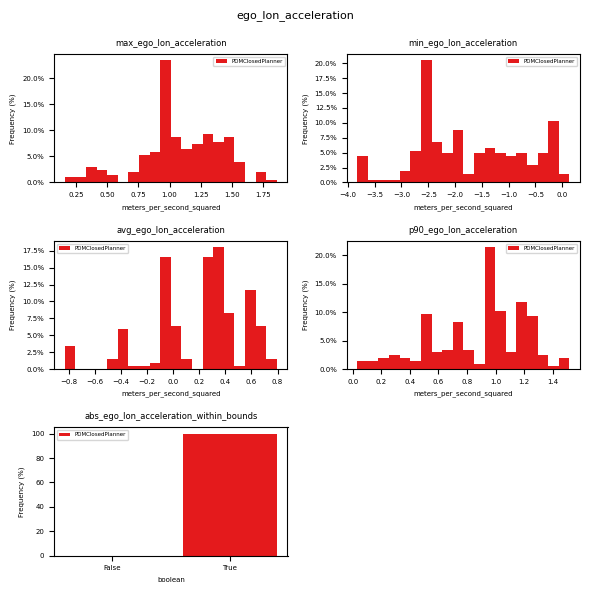

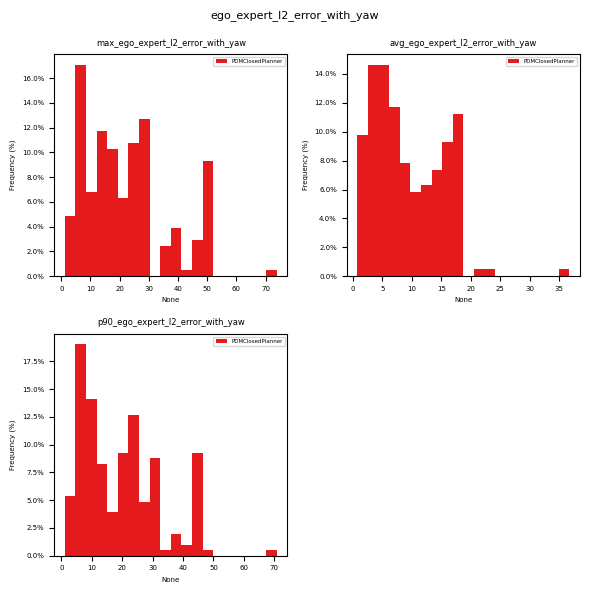

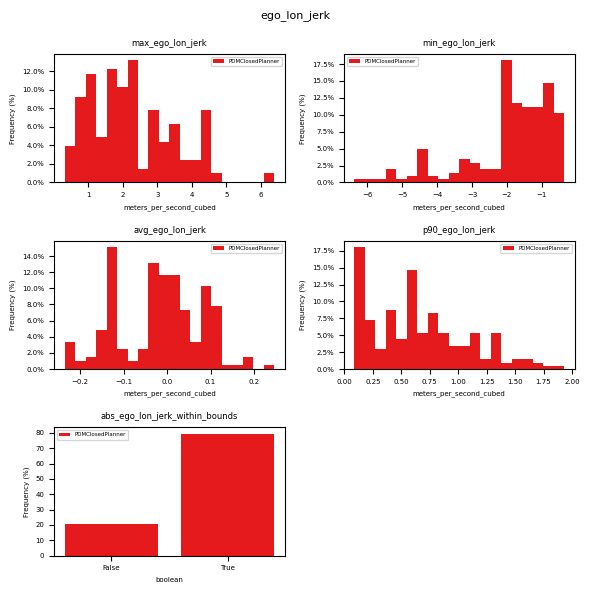

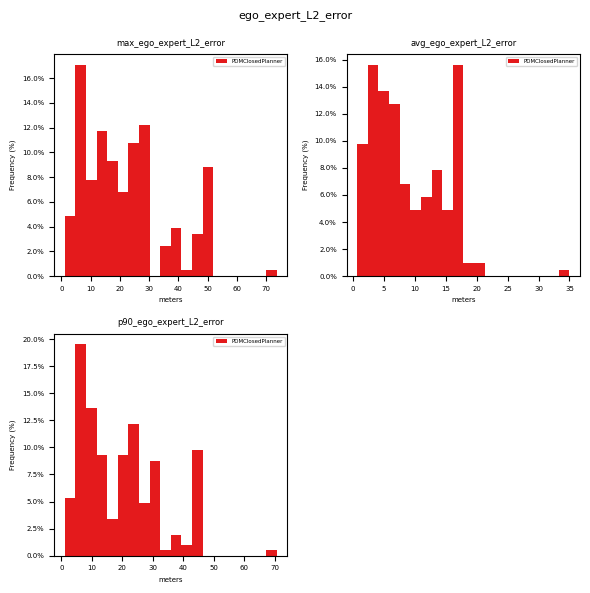

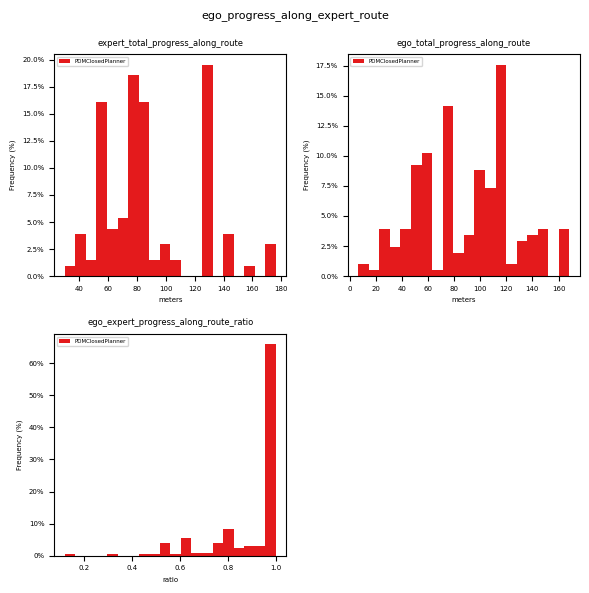

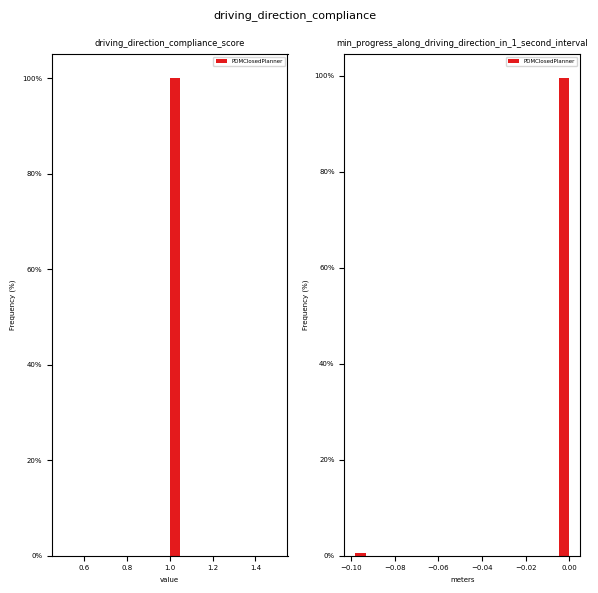

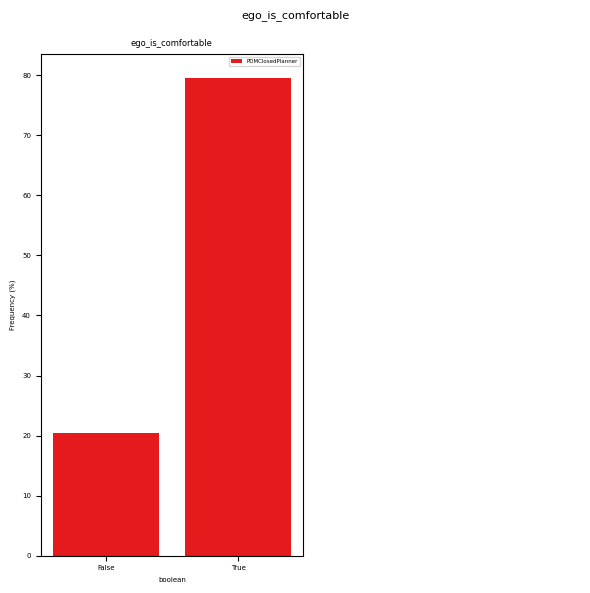

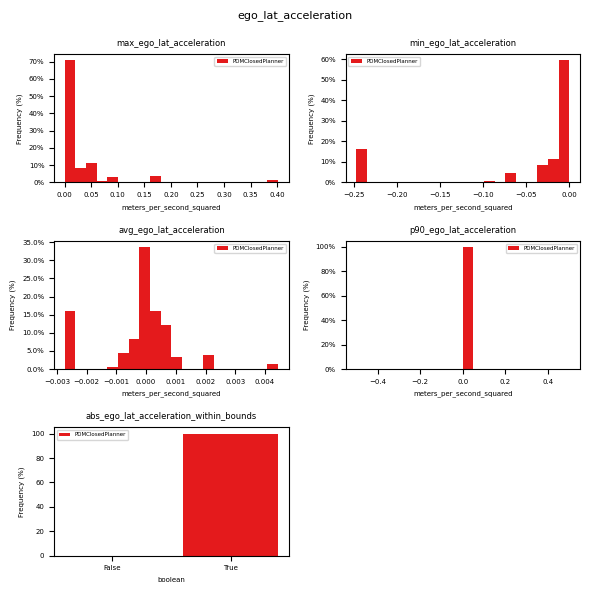

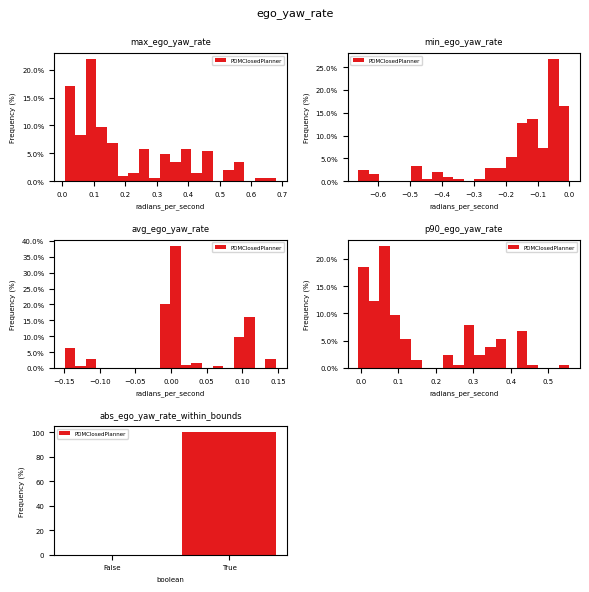

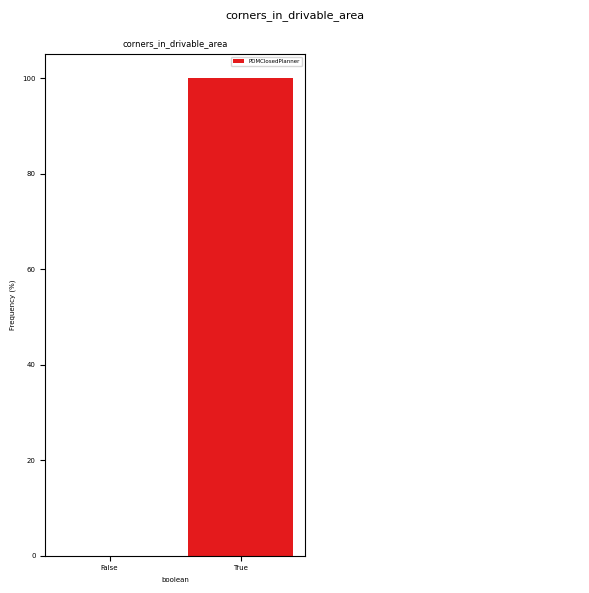

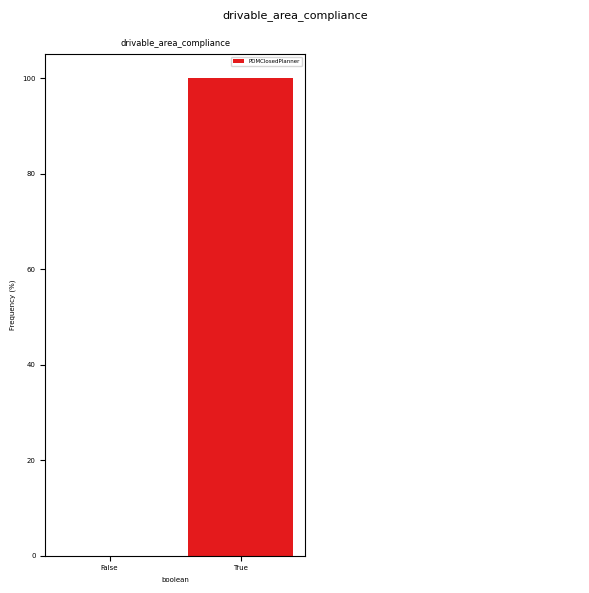

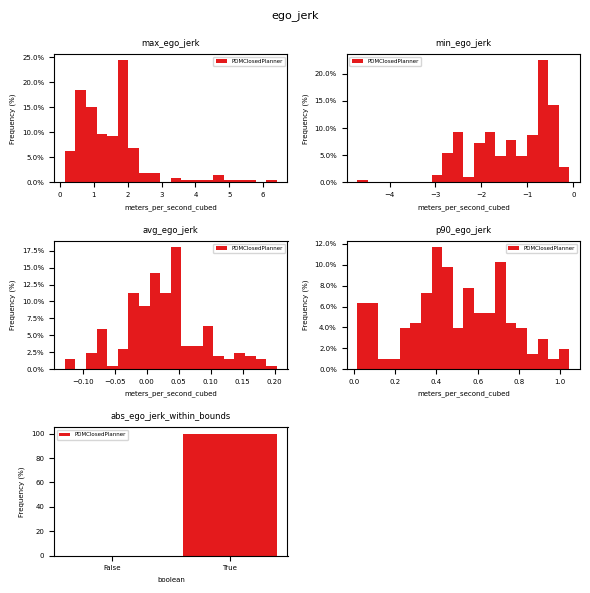

In [8]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg_occ)

# Now we set up the second running regime

In [13]:
#########################################


path = output_folder_occ + "/metrics/"
file_path_1 = path + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_1)
df = df.loc[df["no_ego_at_fault_collisions_stat_value"] == False]
df = df["scenario_name"]


scenario_list = df.tolist()
print(f"+scenarios_to_check_in_alternate_regime={scenario_list}")
cfg_unocc = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        # "model=gc_pgp_model",
        # "model.aggregator.pre_train=false",
        # "planner.ml_planner.model_config=${model}",
        # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
        # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
        # "+observation.model=gc_pgp_model",
        # "+observation.model.aggregator.pre_train=false",
        # "+observation.model_config=${model}",
        # f"+observation.checkpoint_path={gc_pgp_ckpt}",
        f"observation.planner_type=pdm_closed",
        # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
        f"observation.occlusion_cfg.occlusion=false",
        "+modify_scenario_simulations=true",
        "+second_testing_round=true",
        f"+scenarios_to_check_in_alternate_regime={scenario_list}",
        "+modifier_types=[conflict-and-occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right, oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection]
        "+occlusion=false",
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder_unocc = cfg_unocc.output_dir
print('output_folder_unocc = "' + output_folder_unocc + '"')

+scenarios_to_check_in_alternate_regime=['0c308ff01686526d_conflict_injection_and_occlusion_injection_0_natural_occlusion_0.0_70358', '8b80aa05d88b518b_conflict_injection_and_occlusion_injection_3_0.0_48139', '6895e06f4b645c9b_conflict_injection_and_occlusion_injection_0_natural_occlusion_0.0_68924', '8b80aa05d88b518b_conflict_injection_and_occlusion_injection_0_5.0_48139', '0c308ff01686526d_conflict_injection_and_occlusion_injection_0_natural_occlusion_0.0_69963', '8b80aa05d88b518b_conflict_injection_and_occlusion_injection_6_5.0_47826', '8b80aa05d88b518b_conflict_injection_and_occlusion_injection_3_5.0_48139', '8b80aa05d88b518b_conflict_injection_and_occlusion_injection_1_5.0_48139', '6895e06f4b645c9b_conflict_injection_and_occlusion_injection_0_natural_occlusion_0.0_69842', '6895e06f4b645c9b_conflict_injection_and_occlusion_injection_0_natural_occlusion_0.0_69225', '8b80aa05d88b518b_conflict_injection_and_occlusion_injection_0_0.0_48183', '8b80aa05d88b518b_conflict_injection_and_occ

(raylet) [2024-02-28 20:35:38,700 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 665114615808; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-02-28 20:35:48,702 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 665114255360; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-02-28 20:35:58,704 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 665114251264; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-02-28 20:36:08,707 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 665114243072; capacity: 16125711347712. Obj

main_simulation(cfg_unocc)

## Prepare the nuBoard config

In [ ]:
# output_folder_alt = []
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"
# )

In [14]:
scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]

# output_folder_occ = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.27.22.10.46"
# )
# output_folder_unocc = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.01.03.32"
# )
output_folder = [output_folder_occ, output_folder_unocc]

CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

(raylet) [2024-02-28 20:36:28,711 E 10573 10585] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-28_20-06-46_203300_10286 is over 95% full, available space: 665114222592; capacity: 16125711347712. Object creation will fail if spilling is required.


## Launch nuBoard (open in new tab - recommended)


In [ ]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)